# MC Dropout
https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [9]:
# load commons and models module
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
import models 
importlib.reload(cm)
importlib.reload(models)

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


<module 'models' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\models.py'>

# Configuration, Parameters and Setup

In [3]:
# Only needs to be run once per enviroment. Downloads requiered wordnet package for nltk 
cm.one_time_setup()

# Also make sure to have access to the pretrained GloVe embedding model.
# We use glove.6B.zip from https://nlp.stanford.edu/projects/glove/

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Directory containing the GloVe files.
glove_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/glove"

# Directory containing the trained model
models_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/models"

# Directory containing the training history
history_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/history"

# Embedding dimension (all models are pretrained for dimension 50)
embedding_dim = 50

# Fraction of the training dataset to be used. 
dataset_sizes=[1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
dataset_size = dataset_sizes[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 50

# hidden layers where each element denotes the number of neurons
neurons_hidden_layers = [64, 64, 32]

In [11]:
setup = cm.setup(glove_dir=glove_dir,
                 embedding_dim=embedding_dim,
                 dataset_size=dataset_size)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

# number of data points
N = x_train.shape[0]

Found 400000 word vectors.
17361/88587 unknown words


In [12]:
# MC Dropout parameters

# prior lenght scale
lengthscale = 1e-2

# dropout rate for all dropout layers in the network, 1. means drop all
dropout = 0.5

# model precision used for regularization
tau = 1.0

# regularization
reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

# MCMC Samples
T = 500

# Model

In [13]:
mc_dropout_model = models.McDropoutModel(model_setup=setup,
                                  models_dir=models_dir,
                                  history_dir=history_dir,
                                  neurons_hidden_layers=neurons_hidden_layers,
                                  tau=tau,
                                  lengthscale=lengthscale,
                                  dropout=dropout)

In [14]:
mc_dropout_model.keras_summary()

Model: "mc_dropout_23750_64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2800)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2800, 50)          4429400   
_________________________________________________________________
dropout (Dropout)            (None, 2800, 50)          0         
_________________________________________________________________
dense (Dense)                (None, 2800, 64)          3264      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2800, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 2800, 64)          4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2800,

In [16]:
mc_dropout_model.fit(epochs=epochs, batch_size=batch_size)

using saved model
Loaded history successfully. Last epoch: 50
Train on 23750 samples, validate on 1250 samples


# History

In [17]:
(history_df, last_epoch) = mc_dropout_model.load_history()

Loaded history successfully. Last epoch: 50


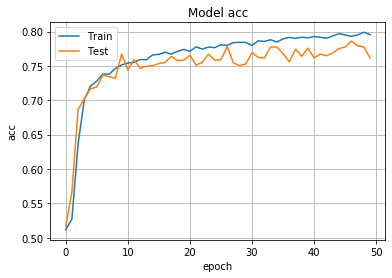

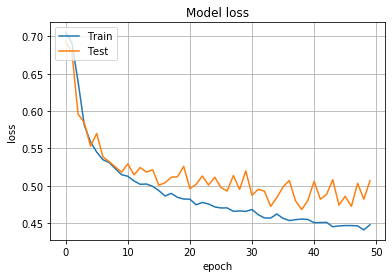

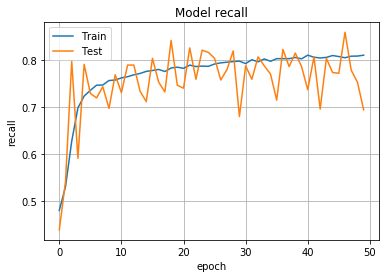

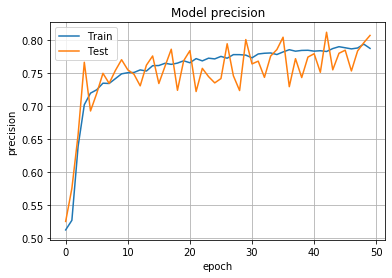

In [19]:
for metric in ["acc", "loss", "recall", "precision"]:
    cm.plot_metric(metric, history_df)
    plt.show()

using saved model
Training data predictions: mean of 0.5 and std of 0.5

<START> on the bright side it ended that's the only thing this movie has going for it of course br br this is the worst movie i have ever seen and i've seen some bad ones this movie is actually so horrible i went and changed my rating for children of the living dead to a 2 just for not being raptor br br official one liner rating come with me to another movie if you want to live
Expected: 0, Predicted mean: 0.308630, rmse: 0.337500, std: 0.136581


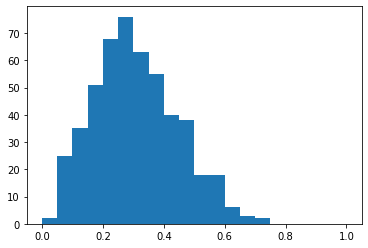




<START> susie q is an original and isn't like those other bad disney film spoiler a boy named zach moves to a new town and has trouble at school he is good basketball a girl in the 1950's died with her boyfriend when their car was crashed off a bridge susie amy jo johnson from the power rangers pink ranger is helping zach as a ghost to get a necklace along the way he must explain to his sister about her ghost and finally getting this necklace susie returns to the bridge she died on and then she gets in the ghostly car of her boyfriend and they float up later as he misses her he finds a girl who looks just like her do you believe in reincarnation susie q is a good movie to see now and then but they barely give because disney needs to fill everything up with stupid movies and shows i give it a br br 7 10
Expected: 1, Predicted mean: 0.572286, rmse: 0.453366, std: 0.150336


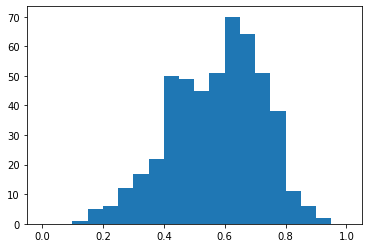




<START> it came as no surprise to me that this was a very depressing and draining movie after all it's all about the impact of war on civilians and it's by the king of depression ingmar bergman in other words so many of bergman's works delve deep into human misery and angst and so this movie seems not so extraordinary coming from this director br br even though it is more difficult to watch the last half of the movie offers perhaps more insight into the lower depths of humanity that's because initially the main characters liv ullman and max von sydow try to overcome adversity and are basically decent though a bit stupid people however as deprivation after deprivation occurs they especially von sydow become less and less humane and more animalistic doing anything in order to survive br br fun to watch no freaking way but an interesting insight into human nature br br ps 1 thing i loved about this film is that it avoided a stupid movie chiche when the couple sat down with the shopkeep

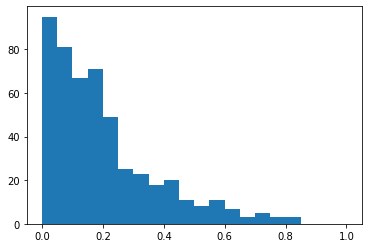




<START> james franco is totally cool in this movie not just handsome and charismatic but genuinely open and vulnerable in a sincere kind of way at the tristan screening some folks were on his back for being pouty and sullen and doing the whole james dean thing but i don't think this true blind spot is proof positive of his tremendous talent in this film he carries himself with a different sort of weight entirely it's a unique performance bittersweet and really moving the lines from his journal cut you like a knife you sense a sharp intelligence of observation behind his words the tone is everything he carries it through the action and suspense as well as the grim bits of gallows humor i like the other two actors a great deal too the blonde girl is totally gorgeous and the man is hysterical in his twisted tough guy stoicism some of the thugs seemed a little sketchy but this is a mini point really the film is totally solid and franco is way cool all around
Expected: 1, Predicted mean:

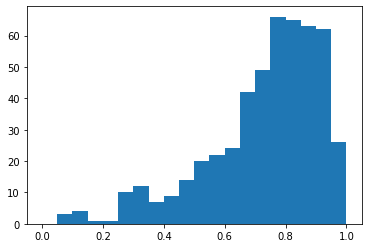




<START> normally i do not review online but it's saturday and i'm trapped in my room on a rainy day with nothing to do but watch sci fi movies and xena warrior princess i can't get the damned the song out of my head it's been there for the past ten years or so just pops up randomly when someone me does something idiotic if you have any complaints about this movie and actually post them on the internet do you have any idea how much of an idiot you look like if you expect more out of bruce campbell than what he puts out in the most literal sense than why in g d's holy name do you watch his movies no one watches a bruce campbell movie when they want to see something genius and intelligible we watch them so we feel better about ourselves like those people who watch jerry springer and eat chunky monkey and to be easily entertained by mindless psycho babble i personally love bruce campbell movies i'm not a complete idiot in fact i see myself as an intellectual and a scholar haha shut up a

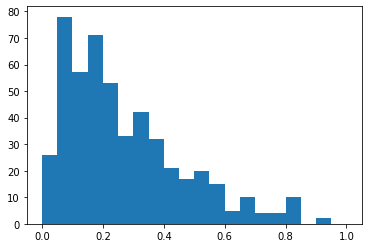




<START> i don't know what the makers of this film were trying to either accomplish or say but they badly failed at whatever it was unless of course the object was to totally confuse the viewer i watched this movie simply because drew barrymore was in it and it turned out that she had a smaller than small cameo in it the whole idea of having this kid go on some wild car trip to win a big money prize from a gas station game and meet up with all sorts of wackos is utterly ridiculous
Expected: 0, Predicted mean: 0.315621, rmse: 0.350402, std: 0.152202


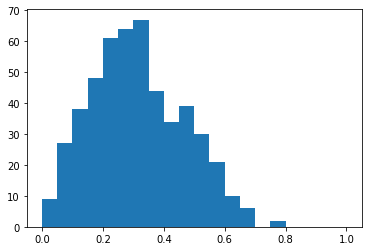




<START> the problem with so many people watching this movie is the mindset they watch it in people come looking for a b grade horror film or a so bad it's good movie jack frost 2 is neither of these br br it is to put it simply a very good movie cleverly hidden inside a very bad one to view it as anything other than a screwball comedy easily funnier than all three absolutely scary movies combined is to the movie on a basic level it would be like watching shawshank redemption and then complaining that there were no explosions br br the premise is simple the characters from the first movie haunted by memories of jack frost take a vacation to a tropical island a new improved jack comes after them now with essentially the powers of hydro man from spider man essentially he can turn from water to snow easily and quickly divide himself multiply himself and worst of all he's managed to grow an immunity to his only former weakness antifreeze br br what's sad about this movie is that the brai

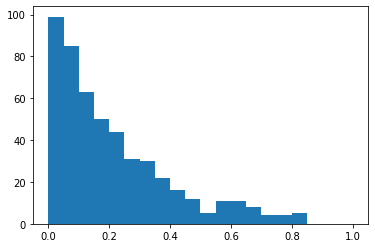




<START> several weeks back i lost my beloved companion and friend of fourteen years a golden retriever named sasha when i came home from the animal hospital alone after having made one of the most painful decisions of my life my teenage daughter sat by my side and we talked about this episode of the twilight zone i could be wrong but i recall a line that arthur hunnicutt said when satan was trying to trick him into hell but his dog could not go with him and his dog in turn was growling in defiance at the gatekeeper who was trying to trick the old hunter to step inside that it would be one helluva of heaven if dogs were not allowed and the spirit of the old mountain man and his dog decided to turn away from the gate of what they had thought was heaven to wander eternity alone what a tearful moment when they meet a good ole' country boy on that eternal road only to discover he is an angel sent out to find 'em and sure neighbor of course dogs are allowed into heaven br br i'll confess 

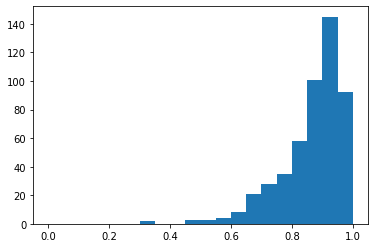




<START> in the mid 1970s my nyc apt building was finally wired for cable tv and since showtime instead of hbo was the only premium channel offered showing recent movies i signed up for it being a writer and night owl by nature i soon discovered the channel was showing movies late at night and until the wee hours of the morning i'd never even heard of most of them american independent films and foreign films that had never been given a u s theatrical release many of them had recognizable star casts and respectable directors and thanks to showtime i discovered many first rate films i and other showtime subscribers would never else have had the opportunity to see most of these cinematic were indeed dogs but often so bad they were unintentionally hilarious one night showtime unveiled a little italian made gem called redneck filmed in 1972 given a limited european release in 1973 even though the movie had never been released in the u s the mpaa rating was listed as an 'r' since the direc

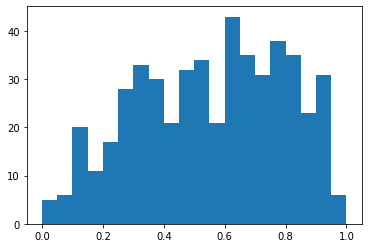




<START> son gets severely wounded during a lion hunt that goes awry hercules a solid and engaging performance by the beefy reg park has to venture into an eerie and dangerous alternate dimension ruled by the evil and vengeful gia the earth goddess a deliciously wicked portrayal by gia and battle various monsters in order to save his son's soul meanwhile equally nasty son a perfectly hateful turn by giovanni poses as hercules and takes over an entire city as a cruel and ruthless tyrant director relates the engrossing story at a steady pace and maintains a serious tone throughout this film begins a little slow but really starts cooking once hercules enters the misty and perilous subterranean spirit world rousing highlights include hercules grappling with a humanoid lizard beast hercules climbing a giant gnarled tree and hercules being attacked by a bunch of creepy rotting zombies better still the bizarre spirit world just reeks of spooky atmosphere gotta love that persistent thick swi

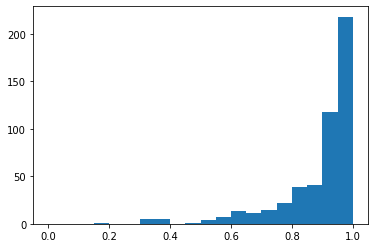




<START> this is a movie that will brighten up your day for sure kermit the frog is just an ordinary frog in his swamp when a talent agent stops by and tells him that hollywood is looking for frogs to be in movie lol on the way kermit meets fozzie bear miss piggy gonzo and his chicken camilla rowlf the electric mayhem bunsen and beaker but also trailing kermit is the proprietor of a restaurant chain doc hoppers french fried frog legs all things considered though kermit and the muppets make it to hollywood br br this movie is recommended for everyone young and old br br it has some wonderful musical numbers like the rainbow connection i'm going to go back there someday and movin' right along the muppets also use many forms of transportation in this movie kermit rides a bike fozzie drives a and another car gonzo takes flight with a bundle of helium balloons which is one of my favorite moments by the way and kermit and the rest of the muppets finally go the rest of the way by the electr

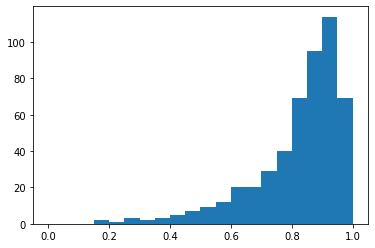




<START> the bbc surpassed themselves with the boundaries they crossed with tipping the velvet in the past they've been 'daring' with dennis potter's works but this mini series as it was screened in the uk is superb andrew davies work is top notch i've not read the sarah water's novel but i can imagine he's done it real justice i comment on the most men have watched it for that proved to be a main talking and selling point when originally advertised the fact is it the lesbian side of society in the 1800s a time when most thought it was old men and rent boys well it was lesbianism took place mainly behind closed and often respectable doors br br you can also look at tipping the velvet as a 'love story' it actually is as well as 'self that many gay bi and straight people go through and comments on this occur and repeat all the time br br if you've not seen it yet either repeated on tv or on dvd get it you'll be in for a treat and even the production and filming of it is perfect just tr

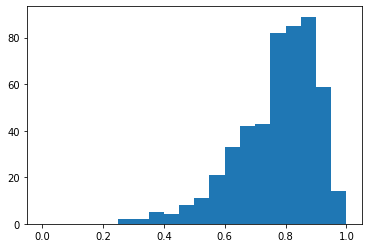




<START> the only entertaining thing that i found about watching this movie was listening to star wars coming through the wall of the movie theatre yes i go to a really bad movie theatre this movie is so mind numbingly bad that i think i would rather have my eyes scratched out by a cat rather than watch it again br br let's compare it to the original one is charming funny exciting well acted and one of the best movies ever made the other is so far from funny that all you can do is hope that your eyeballs will fall out so you don't have to watch any more i'm sorry christina ricci is a fine actress but cannot compare with mills and don't even get me started on doug e doug in a part one occupied by the amazing and absolutely charming dean jones dean jones' tiny part in the new version is the only partially redeeming part of this movie and it is the only reason i can justify a 1 rating also because the imdb doesn't go into negatives
Expected: 0, Predicted mean: 0.553360, rmse: 0.597256, 

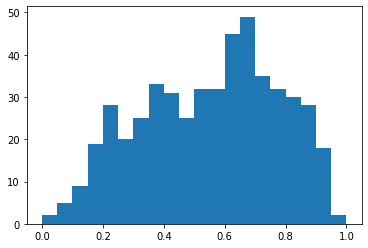




<START> this movie is about a young couple running away to start a new life in la who end up being stalked by a psycho at a deserted rest stop actually it's really just about the girl nicole since her boyfriend literally disappears within a few minutes the movie gets going extremely fast and early on you wonder how it could possibly stretch its story out to feature length it isn't long before you realize that the movie does this by simply wasting time with unnecessary scenes that go nowhere br br the story is not only paper thin but unstructured stupid and incoherent minutes after the disappearance of her boyfriend and car nicole finds a mobile home at the rest stop she sees the flashing of a camera and knows that people are inside but she easily gives up on trying to get their help when no one answers her door knocks after she is informed by the killer that her boyfriend is in danger she walks around the rest stop doing all sorts of stupid and unnecessary things this includes turni

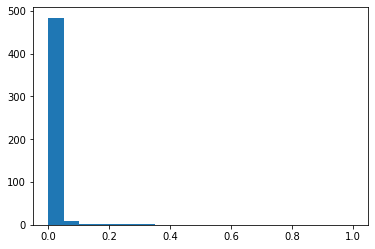




<START> this film did entertain me with lots of laughs at the actors who kept the film moving along in all types of crazy directions if you like suggestive language and sexy looking gals they were all in the picture and gals and guys all looking burned out before they even graduate from high school there is one scene where the teenagers drive their car into a very fake deer and then proceed to throw it out into a lake or ocean which is repeated over and over again there is no horror to this film except the word horrible for the entire picture and arnold who plays a plastic cop is really one sick character please don't waste your time viewing this film
Expected: 0, Predicted mean: 0.299978, rmse: 0.336347, std: 0.152126


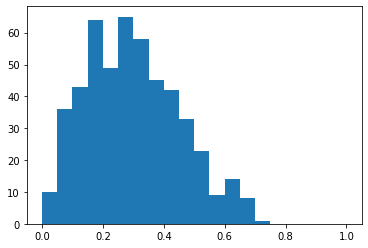




<START> if you are a catalan nationalist socialist with unnuanced reverence for the mythologies of the spanish republic this movie may be for you two brothers real life ones one of them being marc himself re enact a fictional version of a real life journey they had made through the spectacular catalan countryside and history is evoked pans of bullet holed walls artillery booms on the soundtrack but not shown there is very little dialog and most of it is incidental the story is told in a third person voice over the voice being that of an actress impersonating the real life sister of the real life brothers the images have little to do with what story line there is which isn't much many are stunning brooding pans across stark semi arid mountains and rivers think terrence malick or gus van sant there's not a little of both gerry and last days here interspersed with some stunning still images and motionless frames these are best enjoyed within the film's superb natural sound environment 

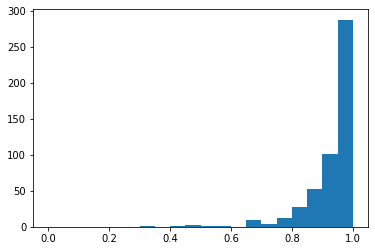




<START> the worst film i have seen in the last 12 months the plot of the story was uninteresting the movie ended when he became khan i always thought there happened something really interesting afterwards i knew that mongolia and all the areas where the movie played have beautiful landscapes but the movie didn't profit from that the jokes where really poor the narrator himself could have told a bit more about mongolian history traditions etc my co viewer knew nothing about that at all so he was a bit lost i was so looking forward to see this film but was really disappointed after all it was one out of 3 movies i have ever seen in cinema where i considered to leave before the end
Expected: 0, Predicted mean: 0.318026, rmse: 0.359342, std: 0.167289


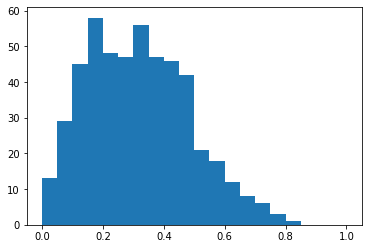




<START> sadly this film lives up to about 1 of the hype that the game created in 2004 and leaves a very sour taste in the mouth for video game enthusiasts book worms and movie fans alike there is nothing more disappointing then a film that is based on an original concept whether on paper or gaming console that does not deliver and not only that goes well under the mark far cry the video game released in 2004 created such a cult following that making a movie from the content should have been easy and scores of gamers would have flocked to watch the film if you are a gamer that has played far cry do not watch this film anyone else who hasn't played the game it'll still seem like a b grade acted b grade directed movie uwe boll hang your head in shame this should've been easy to make into a blockbuster the storyline of the game was incredible think jurassic park meets alien and yet you still managed to take it and mould it into your own terrible recreation of an instant classic video ga

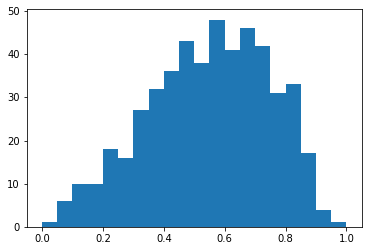




<START> before i start i need to inform you that i love horror films with a passion love them i have seen thousands and rarely does one come along that i do not like i am very forgiving of the horror genre one of the greatest lines in movie history is in the film ed wood where ed wood johnny depp freaks out and yells at the overly critical producers after they comment on plan 9's cheap sets and continuity problems you don't know anything haven't you ever heard of of disbelief ' well i try to bring that suspension of disbelief philosophy with me to every horror film i see and it usually works unfortunately it didn't work for me during the screening of cheerleader massacre br br strike one br br the first thing you'll notice about this film is that it is shot on video and has that crummy hand held home digital camera style the camera work and quality are so bad it makes daytime soaps look breathtaking in comparison in fact it makes troma and full moon video releases look good and that

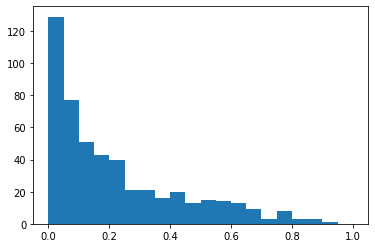




<START> silly disney film about a college student who accidentally discovers a potion that makes things invisible not a bad idea and some of the special effects are pretty good still the script is very bad all the jokes flop and the acting is lousy everybody's trying to be funny and they're not a real boring stupid disney film but it was fun seeing kurt russell so young
Expected: 0, Predicted mean: 0.107079, rmse: 0.145809, std: 0.098967


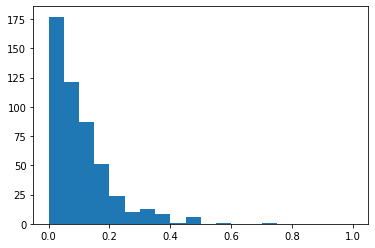




<START> the film begins with a 30 minute explanation about the war the human cyborgs battles history and then dumps 2 actors into a gravel pit they run around this gravel pit desert area for about an hour shooting at each other that's it must have cost about £10 00 to make with change avoid br br marks out of ten acting 9 sets 1 costumes 9 direction 50 production 1 titled intro 4 br br i think to improve this film would be to lose the commentary let the watcher decide what's going on remove some of the awful cgi add some techno rave music to it they might just rescue it
Expected: 0, Predicted mean: 0.243586, rmse: 0.271871, std: 0.120747


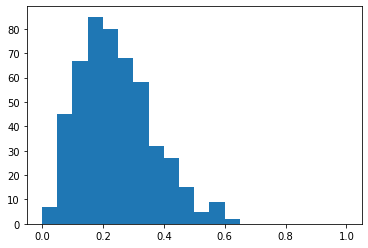




<START> for me the best most memorable movies are often those which on first viewing i know nothing about american movie is a perfect example of just such a gem watching tv late one evening i spotted the one only good review among the dross thankfully i settled in for a real treat american movie is a documentary following the unforgettable mark pronounced orchard i believe a highly articulate charismatic lad as he struggles to write direct and produce midwestern a gritty low budget horror movie on which he has been working for years in mark we discover a young man filled with contrast his appearance is of the classic trailer trash stereotype skinny bum fluff mustache '80s heavy metal styling mullet hairdo etc to camera however mark reveals startling wit insight as he philosophizes upon life love movies the american way as the movie unfolds it sadly becomes clear that mark's lack of discipline heavy drinking are relentlessly sabotaging his creative efforts american movie is a charmin

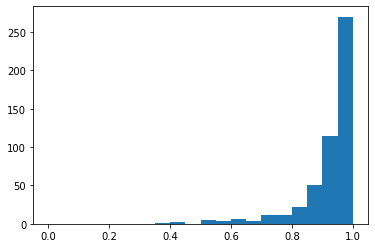




<START> i finally saw laure and i have to say that i equally enjoyed it and was dismayed by it what's great about it is the atmosphere the music the location the cinematography and the beautiful cast the story is non existent for sure but with these movies it doesn't really matter the pace in languid and the settings are exotic the film has a lot going for it unfortunately it also has a few things going against it the first thing is that the gorgeous annie belle and the handsome al cliver have no chemistry whatsoever because the two are playing a couple and are on screen for almost the entire length of the film the lack of chemistry between the two is a definite liability according to imdb al and annie were a real couple when they filmed this movie they sure kept their attraction to each other from showing on screen br br the other problem with laure is that some sex scenes are just ineffective or even ridiculous there's one sex scene that stands out as one of the silliest i've ever

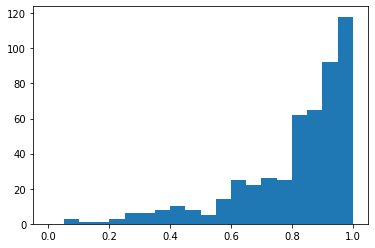




<START> a wealthy young man raised as a son of the gods must confront his chinese heritage while living in a white world br br although the premise upon which this film is based is almost certainly a biological impossibility and the secret of the plot when revealed at the movie's conclusion makes all which has preceded it faintly ludicrous the story still serves up some decent entertainment and good acting br br richard has the title role as the sweet natured oriental whose life is terribly complicated because he looks caucasian keeps the tone of his performance serious throughout gazing intently into the middle distance a mannerism he developed during silent days whenever his character is indecently misused he makes no attempt to replicate his classic performance in d w griffith's broken blossoms 1919 and this is to his credit beautiful constance bennett is the millionaire's daughter who makes miserable she is gorgeous as always but her behavior does not endear her to the viewer an

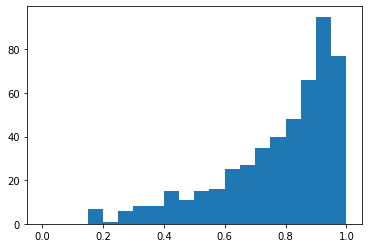




<START> if you feel like wasting 86 minutes on a film that makes no sense is badly written with a bad plot and bad acting then this little gem is for you recommended for those who are about to fall asleep major annoyance will be felt by the awake viewer do not pay to see this movie
Expected: 0, Predicted mean: 0.203547, rmse: 0.238715, std: 0.124713


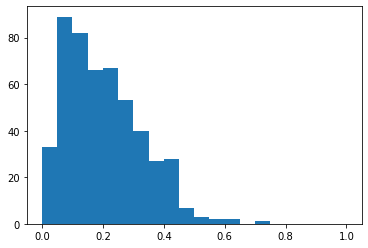

In [20]:
model = mc_dropout_model.load_model()
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)

print("Training data predictions: mean of %s and std of %s\n" % (mean_y_train, std_y_train))

def calc_rmse(y1, y2):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y1, y2))))

def calc_log_likelihood(y, Yt_hat):
    return (tf.reduce_logsumexp(-0.5 * tau * (y - Yt_hat)**2., 0)
            - np.log(T) 
            - 0.5 * np.log(2 * np.pi) 
            - 0.5 * np.log(tau)) # paper states -0.5 as correct. Implementation states +0.5

def reduce_rmse(X_test, y_test, mc_samples=1):
    """
    MC dropout: Equivalent to performing T sochastic forward passes through the network and averaging the results. 
    """
    Y_samples = np.array([model.predict(X_test, batch_size=500, verbose=0) for _ in range(mc_samples)])
    mc_pred = np.mean(Y_samples * std_y_train + mean_y_train, 0)
    return (calc_rmse(y_test, mc_pred), Y_samples)


# predict(x_test_padded, y_test)
# (0.5039183, 0.49860904, -1.0451484)

def predict(X_test, y_test):
    """
        Function for making predictions with the Bayesian neural network.
        @param X_test   The tensor of features for the test data
        @param y_test   The tensor of labels for the test data
    """
        
    X_test = np.array(X_test, ndmin = 2)
    y_test = np.array(y_test, ndmin = 2, dtype="f").T

    # predictive mean and variance for the target variables of the test data
    rmse_standard_pred = reduce_rmse(X_test, y_test)[0]
    rmse, Y_samples = reduce_rmse(X_test, y_test, mc_samples=T)
    Yt_hat = Y_samples * std_y_train + mean_y_train

    log_likelihood = calc_log_likelihood(y_test, Yt_hat)
    mean_log_likelihood = np.mean(log_likelihood)

    return rmse_standard_pred, rmse, Y_samples, (mean_log_likelihood, log_likelihood)

test_size = 25
rmse_standard_pred, rmse, Y_samples, (mean_log_likelihood, log_likelihood) = predict(x_test_padded[:test_size], y_test[:test_size])
for i in range(test_size):
    samples = Y_samples[:, i]
    sentence = word_index.vec2sentence(x_test[i])
    expected = y_test[i]
    pred_mean = np.mean(samples, 0)
    rmse = calc_rmse(samples, expected)
    std = np.std(samples)
    
    print("%s\nExpected: %i, Predicted mean: %f, rmse: %f, std: %f" % (sentence, expected, pred_mean, rmse, std))
    plt.hist(samples, bins=20, range=(0,1))
    plt.show()
    print("\n\n")